## Import Tensorflow Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Create our Training Dataset and Validation Dataset

In [2]:
data_dir = "nvme_drive/Training Data"
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 64
img_height = 180
img_width = 180
train_ds = train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=12322,
  image_size=(img_height, img_width),
  batch_size=batch_size)




val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=12322,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print(class_names)
print("Number of classes found: " + str(num_classes))

Found 673148 files belonging to 4 classes.
Using 538519 files for training.
Found 673148 files belonging to 4 classes.
Using 134629 files for validation.
['Gore', 'None', 'Pornographic', 'Racy']
Number of classes found: 4


## Create Model

### Resize and Rescale all Datasets

In [3]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])


val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

#Data augmentation should only be applied to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

#Buffered prefetching applied to all datasets
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

#Caching and prefetching the validation dataset. If the execution stalls this might cause a crash because we run out of memory.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


#### Dropout regularization of the Network

In [4]:
model = tf.keras.applications.ResNet50V2(weights = None, input_shape = (img_width, img_height ,3), classes=num_classes)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 92, 92, 64)   0           ['conv1_conv[0][0]']    

## Train the Model

In [ ]:
epochs=120
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Get Training Results

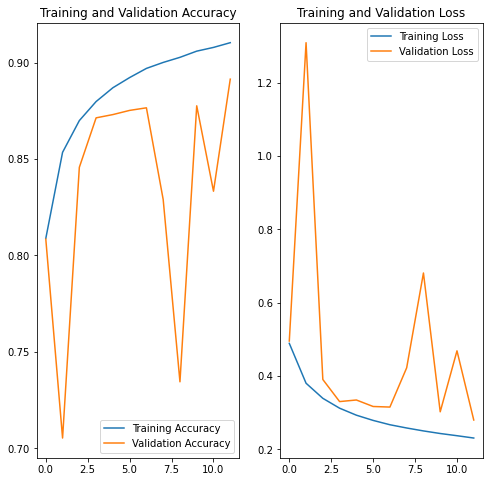

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test Our Model

In [9]:
#Predict on the current dataset
image_path = ""
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

FileNotFoundError: [Errno 2] No such file or directory: ''

## Save our Dataset

In [8]:
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
model.save("nvme_drive/Trained Models/" + timestr + "-SafetyNet")